In [1]:
import tensorflow as tf
import numpy as np
import cPickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

In [2]:
def unpickle( file ):
    fo = open(file, 'rb')
    data_dict = cPickle.load(fo)
    fo.close()
    return data_dict
 
data = unpickle( '../data/cifar-10-batches-py/data_batch_1' )
features = data['data']
labels = data['labels']
labels = np.atleast_2d( labels ).T

# split the data into train/test sets
train_pts, test_pts, train_labels, test_labels = train_test_split(features, labels, test_size=.2)
# whiten the data
mu = np.mean(features, axis=0)
std = np.std(features, axis=0)
train_pts_shift = (train_pts - mu)/std
test_pts_shift = (test_pts - mu)/std

In [4]:
def conv(x, filter_size=3, stride=2, num_filters=64, is_output=False, name="conv"):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Convolve x with W by calling the tf.nn.conv2d function
      Add the bias
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    ''' 
    shape = x.get_shape().as_list()
    with tf.name_scope(name) as scope:
        W = tf.get_variable("W_{}".format(name), [filter_size, filter_size, shape[-1], num_filters], 
                             dtype = tf.float32, initializer = tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b_{}".format(name), [num_filters], dtype = tf.float32, 
                            initializer = tf.contrib.layers.variance_scaling_initializer())
        C = tf.nn.conv2d(x, W, [1, stride, stride, 1], padding="SAME")
        C1 = tf.nn.bias_add(C, b)
        if not is_output:
            h = tf.nn.relu(C1)
            return h
    return C1

def fc(x, out_size=50, is_output=False, name="fc"):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Multiply x by W and add b
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    '''
    shape = x.get_shape().as_list()
    with tf.name_scope(name) as scope:
        W = tf.get_variable("W_{}".format(name), [out_size, shape[0]], 
                             dtype = tf.float32, initializer = tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b_{}".format(name), [out_size], dtype = tf.float32, 
                            initializer = tf.contrib.layers.variance_scaling_initializer())
        M = tf.matmul(W, x)
        M1 = tf.nn.bias_add(tf.transpose(M), b)
        if not is_output:
            h = tf.nn.relu(M1)
            return h
    return M1

In [7]:
tf.reset_default_graph()    

x = tf.placeholder(tf.float32, [1,32,32,3])
y_hat = tf.placeholder(tf.int64, [1])
y_true = tf.placeholder(tf.int64, [1])

h0 = conv(x, name="h0") # [1, 16, 16, 64]
h1 = conv(h0, is_output=True, name="h1") # [1, 8, 8, 64]
flat = tf.reshape(h1, [4096, 1])
fc0 = fc(flat, name="fc0")
fc0 = tf.reshape(fc0, (int(fc0.shape[1]),1))
logits = fc(fc0, out_size=10, is_output=True, name="outputs") # [1,10]
print logits.shape

with tf.name_scope("loss_function") as scope:
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_true)

with tf.name_scope("accuracy") as scope:
    y_hat = tf.argmax(logits[0], output_type = tf.int64)
    correct_prediction = tf.equal(y_true, y_hat)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
train_step = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy)

h0  (1, 16, 16, 64)
h1  (1, 8, 8, 64)
fc0  (1, 50)
fc0 reshape  (50, 1)
(1, 10)


In [6]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

train_writer = tf.summary.FileWriter("./tf_logs", sess.graph)

tf.summary.scalar('cross_entropy', cross_entropy)
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()

accuracies, losses = [], []

for i in xrange(100000):
    ind1 = np.random.randint(len(train_pts_shift))
    pt = train_pts_shift[ind1].reshape((1,32,32,3))
    sess.run([train_step, cross_entropy, accuracy], feed_dict={x: pt, y_true: train_labels[ind1]})
    if i % 1000 == 0:
        test_acc, test_xent = 0, 0
        for j, pt in enumerate(test_pts_shift):
            p = pt.reshape((1,32,32,3))
            _, xent, acc = sess.run([train_step, cross_entropy, accuracy], feed_dict={x: p, y_true: test_labels[j]})
            test_acc += acc
            test_xent += xent
        accuracies.append(test_acc/len(test_pts))
        losses.append(test_xent/len(test_pts))
        print '{} ACCURACY: {}\t LOSS: {}'.format(i, test_acc/len(test_labels), test_xent/len(test_labels))
        print '-'*20

train_writer.close()

0 ACCURACY: 0.1225	 LOSS: [ 34.36916733]
--------------------
1000 ACCURACY: 0.1595	 LOSS: [ 17.2253933]
--------------------
2000 ACCURACY: 0.1585	 LOSS: [ 10.88394928]
--------------------
3000 ACCURACY: 0.147	 LOSS: [ 4.23733759]
--------------------
4000 ACCURACY: 0.128	 LOSS: [ 2.53181839]
--------------------
5000 ACCURACY: 0.123	 LOSS: [ 2.36201191]
--------------------
6000 ACCURACY: 0.1265	 LOSS: [ 2.32540369]
--------------------
7000 ACCURACY: 0.135	 LOSS: [ 2.29934692]
--------------------
8000 ACCURACY: 0.1425	 LOSS: [ 2.26912737]
--------------------
9000 ACCURACY: 0.146	 LOSS: [ 2.25082636]
--------------------
10000 ACCURACY: 0.157	 LOSS: [ 2.22514319]
--------------------
11000 ACCURACY: 0.155	 LOSS: [ 2.22167993]
--------------------
12000 ACCURACY: 0.154	 LOSS: [ 2.20809412]
--------------------
13000 ACCURACY: 0.158	 LOSS: [ 2.19692659]
--------------------
14000 ACCURACY: 0.16	 LOSS: [ 2.19129109]
--------------------
15000 ACCURACY: 0.1635	 LOSS: [ 2.17068505]
---

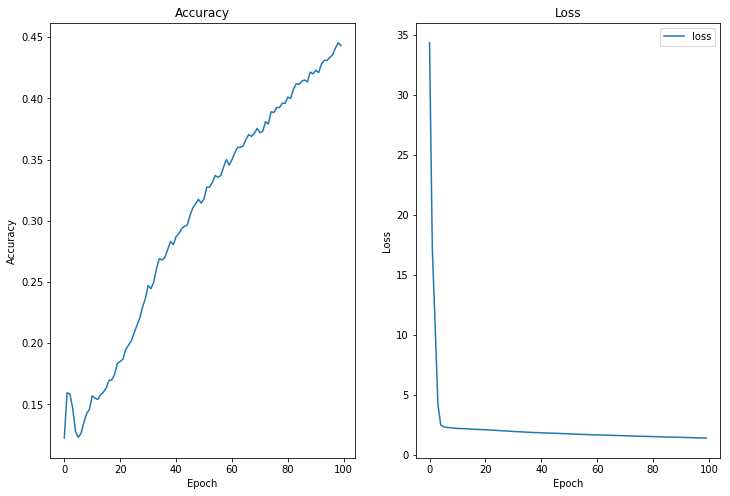

In [8]:
plt.subplot(121)
plt.plot(np.arange(100), accuracies, label='accuracy')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.subplot(122)
plt.plot(np.arange(100), losses, label="loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.show()

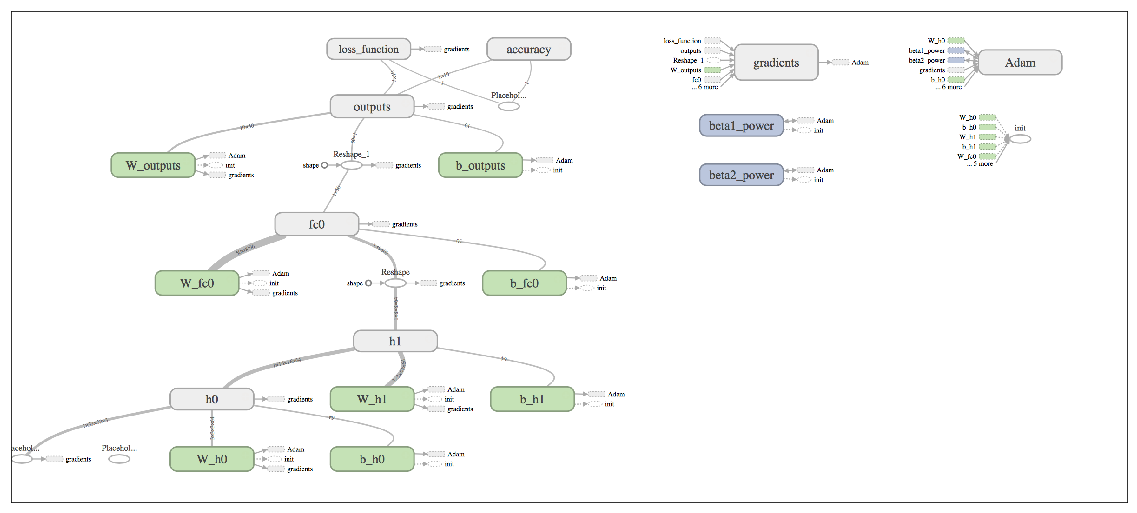

In [11]:
plt.rcParams['figure.figsize'] = [20,15]
img = plt.imread('comp_graph.png')
imgplot = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()